In [1]:
from ringflip_hamiltonian import RingflipHamiltonian, build_matrix, ring_exp_values
import scipy.sparse.linalg as sLA
import numpy.linalg as LA
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



In [2]:

rfh = RingflipHamiltonian([[2,0,0],[0,2,0],[0,0,2]])
rfh.calc_basis(nthread=8)


def calc_ring_exp_vals(rfh:RingflipHamiltonian, g, algo='sparse', krylov_dim=80):
    # calculates the rimg expectation values o nthe four sublats, including degeneracies
    H = build_matrix(rfh, g=g)

    alg_opts = {
        'sparse': lambda hh : sLA.eigs(hh,k=krylov_dim,which='SR'),
        'dense':  lambda hh : LA.eigh(hh.todense())
    }
    
    e,v = alg_opts[algo](H)
    mask = (e-e[0]) < 1e-10
    
    degen_energy = e[mask]
    degen_psi = v[:,mask]
    # print(f"degeneracy: {degen_energy.shape[0]}")
    O_list = ring_exp_values(rfh, degen_psi)

    tallies = {}
    num_entries = {}
    for ring in rfh.ringflips:
        tallies[ring.sl] = 0.
        num_entries[ring.sl] = 0
    
    for ring, O in zip(rfh.ringflips, O_list):
        tallies[ring.sl] += O
        num_entries[ring.sl] += 1

    for k in tallies:
        if num_entries[k] > 0:
            tallies[k] /= num_entries[k];

    return tallies, e

    


Dimension of basis: 2970


In [27]:
H = build_matrix(rfh,  [-4,1,1,1])
e, v = LA.eig(H.todense())
e = np.real(e)
mask = np.argsort(e)
e = e[mask]
v = v[:, mask]



In [35]:
psi = v[:,np.abs(e-e[1]) < 1e-9]
# psi = v[:,0]
psi.conj().T @ rfh.ring_L_ops[0] @ psi

array([[ 0.25156988+0.j, -0.0093185 +0.j, -0.00347794+0.j],
       [-0.0093185 +0.j,  0.24511244+0.j, -0.00301584+0.j],
       [-0.00347794+0.j, -0.00301584+0.j,  0.2344619 +0.j]])

In [49]:
# ππ00 sweep
g_vals_pipi00 = np.linspace(-1,1,10)
res_pipi00 = []
for gg in tqdm(g_vals_pipi00):
    res_pipi00.append(calc_ring_exp_vals(rfh,[gg,gg,1,1]))


100%|███████████████████████████████████████████| 10/10 [00:43<00:00,  4.36s/it]


Text(0.5, 1.0, 'Spectrum as function of 110 magnetic field')

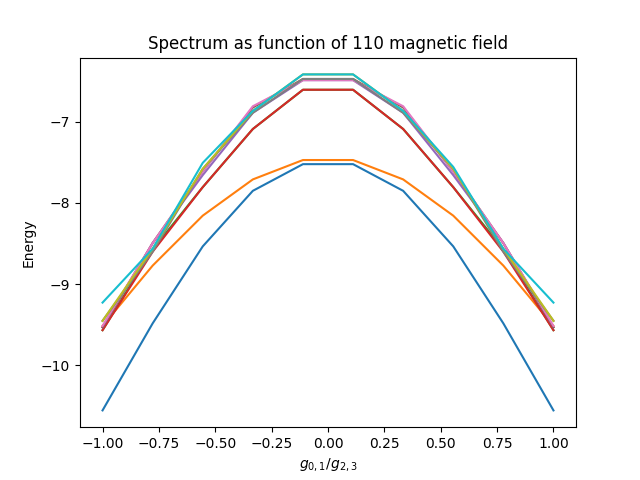

In [124]:
fig, ax = plt.subplots()

ax.plot(g_vals_pipi00, [e[:10] for _,e in res_pipi00])

ax.set_xlabel(r"$g_{0,1}/g_{2,3}$")
ax.set_ylabel("Energy")
ax.set_title("Spectrum as function of 110 magnetic field")

In [76]:
# reports the effective g values at a givem Jpm and field
# Optionally may specify E for selfconsistent Green function calculation
# (E=0 is the "weak-perturbation" approximation, valid if spinon well gapped)
# (actually it's a bit worse - need the zero-order correction as well :( )
def g_from_Jpm(Jpm, B, E=0):
    Jyy=1 # work in these units
    n = np.array([[1,1,1], [1,-1,-1], [-1,1,-1],[-1,-1,1]])/np.sqrt(3)
    BdotN = n@B
    return 1.5 * Jpm**3 / (E-Jyy)**2 + 5/4 * (Jpm**2 * BdotN**2) / (E - Jyy)**3

g_from_Jpm(0.05, 0.3*np.array([1,1,1]))

array([-6.5625e-04,  9.3750e-05,  9.3750e-05,  9.3750e-05])

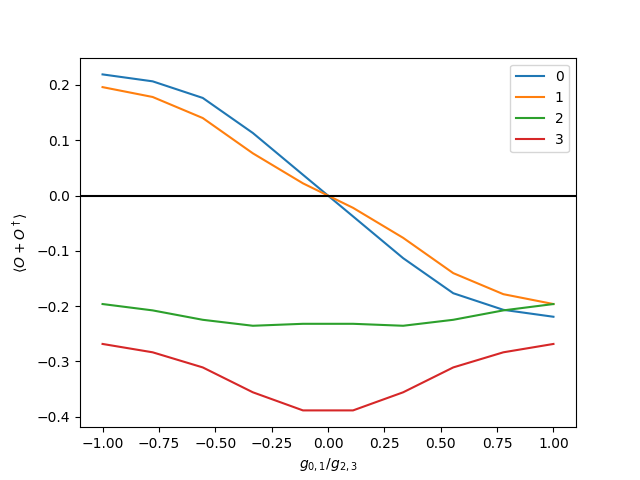

In [121]:

def plot_rings(ax, gg, res):
    
    for mu in range(4):
        ax.plot(gg, [np.real(O[mu][0,0]) for O,_ in res],label=mu)
    
    ax.axhline(0,color='k')
    
    ax.set_ylabel(r'$\langle O + O^\dagger \rangle$')
    ax.legend()
    ax.set_xlabel(r'$g_{0,1}/g_{2,3}$')

fig, ax = plt.subplots()

plot_rings(ax, g_vals_pipi00, res_pipi00)

In [122]:
# FF sweep
g_vals_FF = np.linspace(-4,1,100)
res_FF = []
for gg in tqdm(g_vals_FF):
    res_FF.append(calc_ring_exp_vals(rfh,[gg,1,1,1]))


100%|█████████████████████████████████████████| 100/100 [53:09<00:00, 31.90s/it]


Text(0.5, 0, '$g_0/|g_{1,2,3}|$')

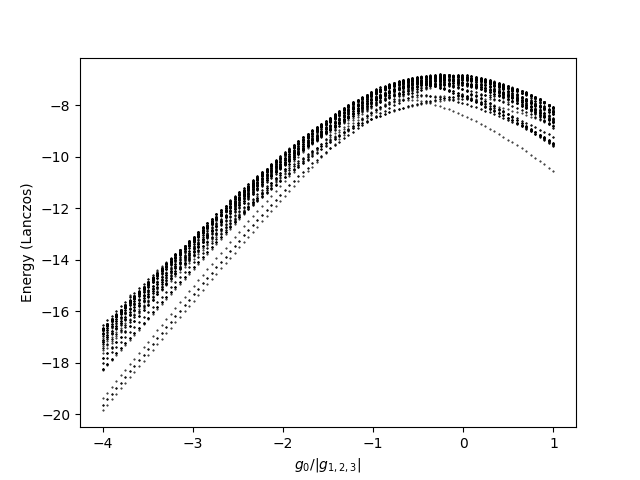

In [123]:
%matplotlib widget
fig, ax = plt.subplots()

ax.plot(g_vals_FF, [np.real(e) for _,e in res_FF],'k.',ms=0.9)

ax.set_ylabel('Energy (Lanczos)')
ax.set_xlabel(r'$g_0/|g_{1,2,3}|$')

Text(0.5, 0, '$g_0/|g_{1,2,3}|$')

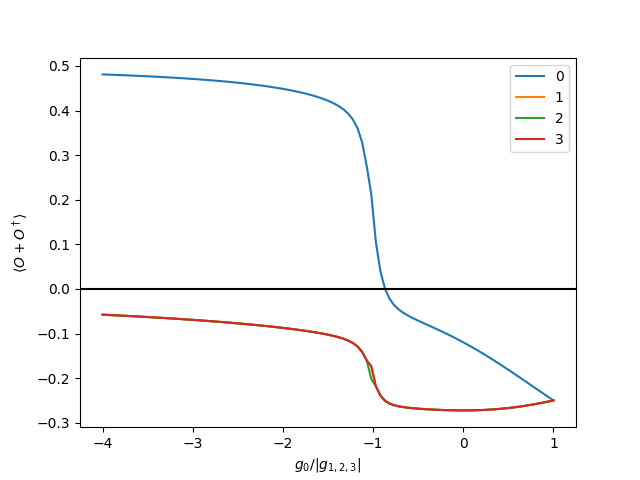

In [61]:
fig, ax = plt.subplots()
plot_rings(ax, g_vals_FF, res_FF)
ax.set_xlabel(r'$g_0/|g_{1,2,3}|$')